In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fft_file = np.load('../fft_matrices_small.npz')

In [3]:
in_fft = fft_file['fft_in']
out_fft = fft_file['fft_out']

In [4]:
in_first = in_fft[0]
out_first = out_fft[0]

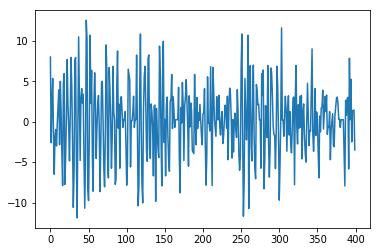

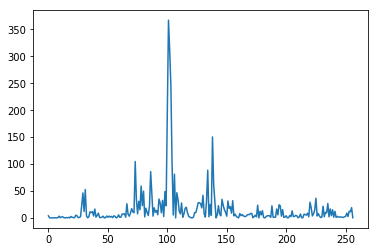

In [26]:
plt.figure()
plt.plot(in_first)
plt.figure()
plt.plot(out_first)

In [6]:
N = 512
K_ = 512

weights = np.zeros((512, 512), dtype=np.complex)

out = []
for k in range(0,K_):
    x_out = 0
    for n in range(0, N):
        w = np.exp(-1j*k*n*((2*np.pi)/N))
        weights[k, n] = w 
        if n < len(in_first):
            x_n = in_first[n] * w
        else:
            x_n = 0 * w
        x_out += x_n
    out.append(x_out)
out = np.asarray(out)

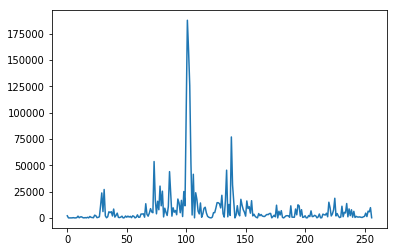

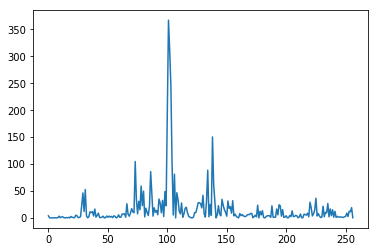

In [45]:
from keras import backend as K

weights = np.zeros((512, 400, 2))
for k in range(0,K_):
    for n in range(0, 400):
        w = np.exp(-1j*k*n*((2*np.pi)/N))
        weights[k, n, 0] = w.real
        weights[k, n, 1] = w.imag


        
def activation(in_first):
    s = in_first
    s = K.expand_dims(s, 1)
    prod = (weights.transpose() * s)
    aggregated = K.sum(prod, axis=1)
    out_agg = K.sum(K.square(aggregated), axis=0)
    return out_agg
    
out = K.eval(activation(in_first))
plt.plot(out[:257])
plt.figure()
plt.plot(out_first)

In [110]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class FftLayer(Layer):

    def __init__(self, **kwargs):
        super(FftLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.we = np.zeros((512, 400, 2))
        for k in range(0,K_):
            for n in range(0, 400):
                w = np.exp(-1j*k*n*((2*np.pi)/N))
                self.we[k, n, 0] = w.real
                self.we[k, n, 1] = w.imag
        super(FftLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        prod = (self.we.transpose(2,0,1) * x)
        aggregated = K.sum(prod, axis=2)
        out_agg = K.sum(K.square(aggregated), axis=0)
        return K.expand_dims(out_agg[:257], axis=0)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 257)

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    FftLayer(input_shape=(400,))
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fft_layer_14 (FftLayer)      (None, 257)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [112]:
x = np.expand_dims(in_fft[0], axis=0)
y = model.predict(x)

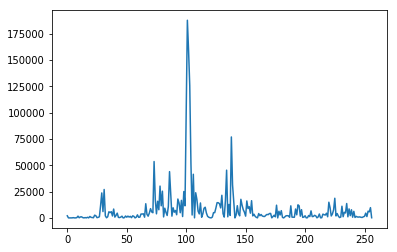

In [115]:
plt.plot(y.transpose())